In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path

In [25]:
def visualize_results(file_path='results_metrics.csv'):
    """
    Visualize the results metrics from the CSV file.

    Parameters:
        file_path (str): Path to the results CSV file.
    """
    # Read the CSV file
    if not os.path.exists(file_path):
        print(f"File '{file_path}' does not exist.")
        return
    
    data = pd.read_csv(file_path)

    # Reorder rows alphabetically by dataset_name
    data = data.sort_values(by='dataset_name')

    # Define the metrics to compare
    metrics = ['accuracy', 'f1_score', 'auc', 'precision', 'recall']

    # Create a grouped bar chart for each metric
    for metric in metrics:
        proposed_col = f'proposed_{metric}'
        baseline_col = f'baseline_{metric}'

        # Extract data for the current metric
        datasets = data['dataset_name']
        proposed_values = data[proposed_col]
        baseline_values = data[baseline_col]

        # Set up the bar chart
        x = np.arange(len(datasets))  # the label locations
        width = 0.35  # the width of the bars

        # Highlight datasets where proposed outperforms baseline
        colors = ['green' if proposed > baseline else '#1f77b4' 
                  for proposed, baseline in zip(proposed_values, baseline_values)]

        fig, ax = plt.subplots(figsize=(10, 6))
        bars1 = ax.bar(x - width/2, proposed_values, width, label='Proposed', color=colors)
        bars2 = ax.bar(x + width/2, baseline_values, width, label='Baseline', color='gray')

        # Add labels, title, and legend
        ax.set_xlabel('Dataset')
        ax.set_ylabel(metric.capitalize())
        ax.set_title(f'Comparison of Proposed vs Baseline for {metric.capitalize()}')
        ax.set_xticks(x)
        ax.set_xticklabels(datasets, rotation=45, ha='right')
        ax.legend()

        # Add value annotations on top of bars with smaller font size
        for bar in bars1:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=6)
        for bar in bars2:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=6)

        # Show the plot
        plt.tight_layout()
        plt.show()

In [26]:
ROOT_DIR = Path().cwd()
while not ROOT_DIR.joinpath("data").exists():
    ROOT_DIR = ROOT_DIR.parent
os.chdir(ROOT_DIR)

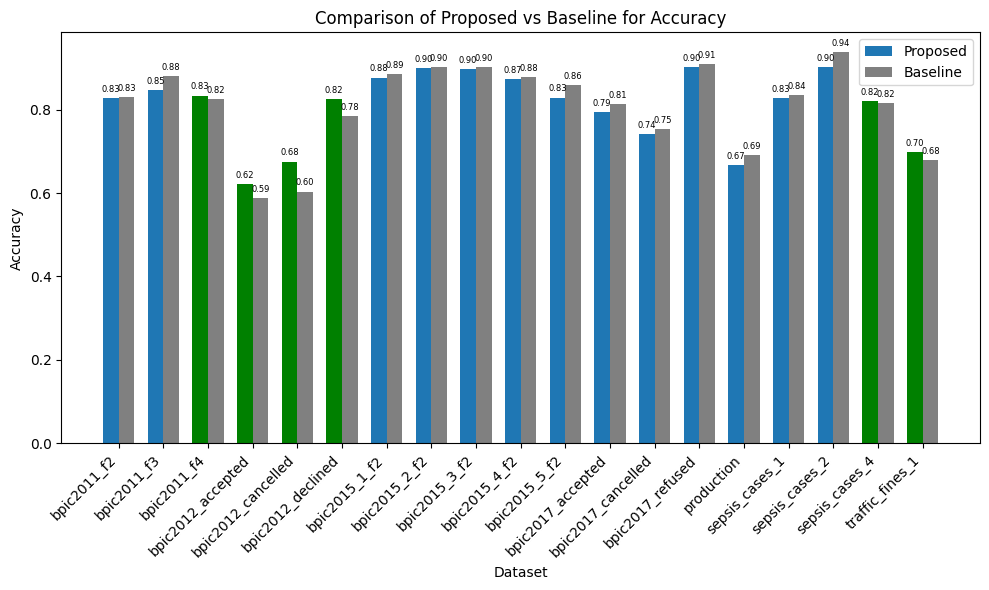

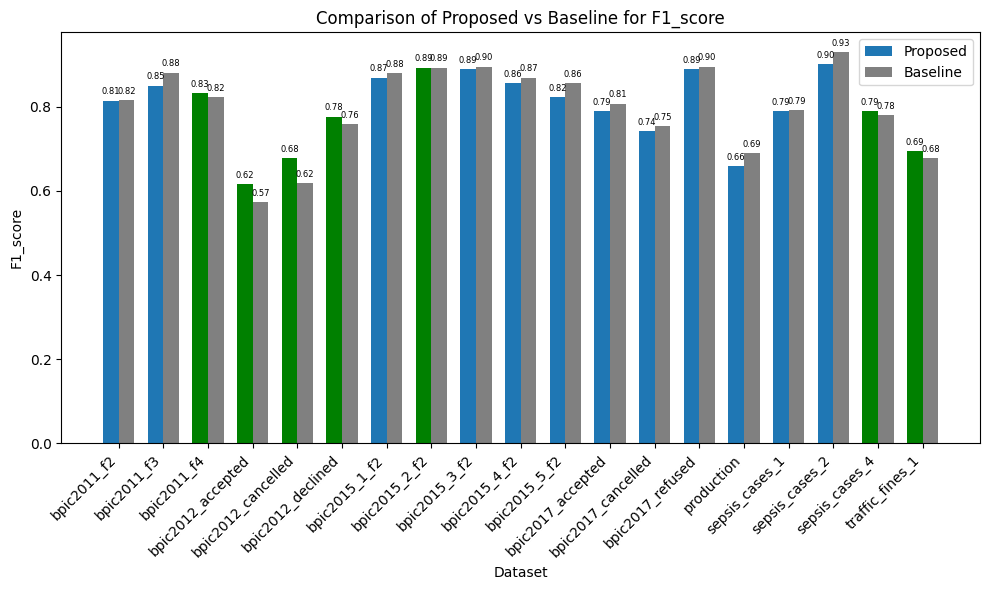

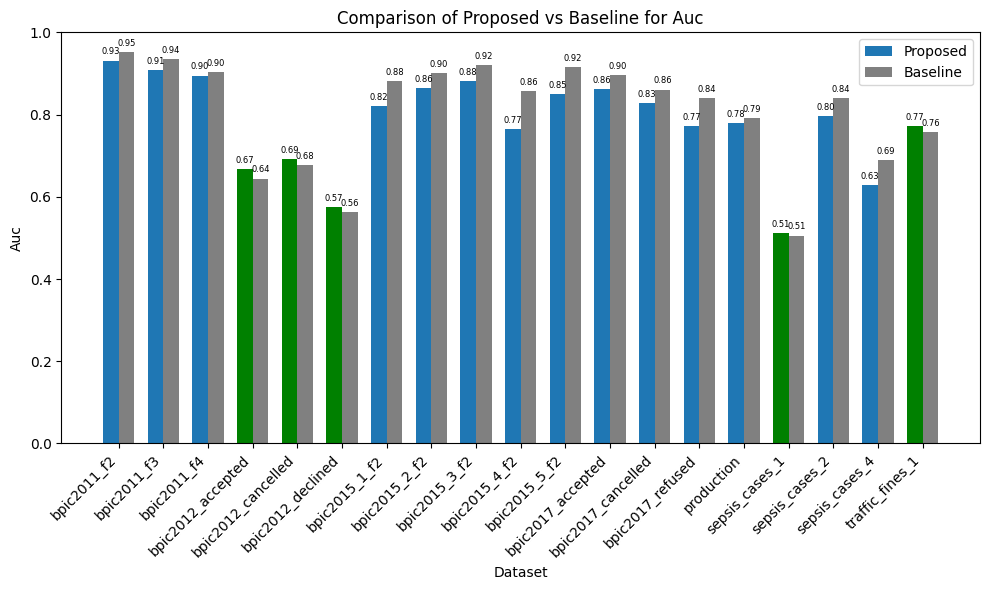

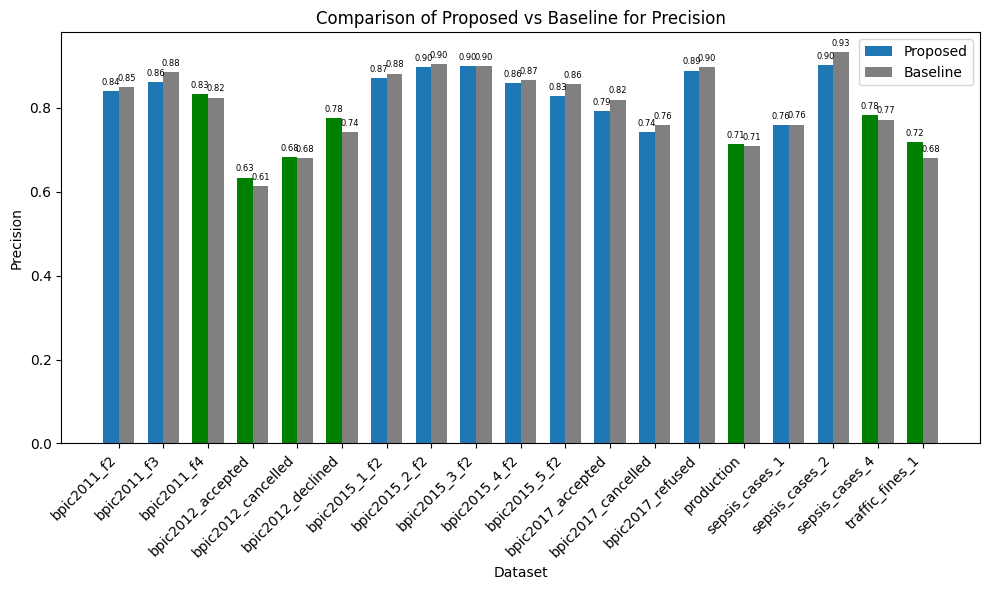

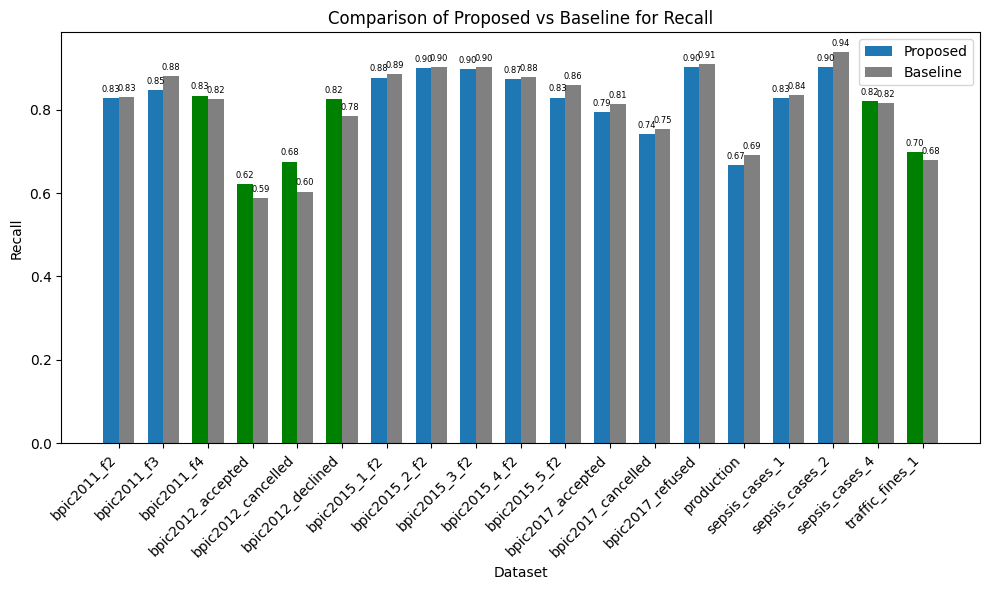

In [27]:
# Call the function to visualize results
visualize_results('results_metrics.csv')

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif

def analyze_feature_size_and_metrics(results_file, dataset_file):
    """
    Analyze feature size and metrics based on the results file and dataset.

    Parameters:
        results_file (str): Path to the results_metrics.csv file.
        dataset_file (str): Path to the dataset file.

    Returns:
        None
    """
    # Step 1: Read the results file
    if not os.path.exists(results_file):
        print(f"Results file '{results_file}' not found.")
        return
    results_df = pd.read_csv(results_file)
    print("Results file loaded successfully.")
    print(results_df.head())

    # Step 2: Load the dataset and get its shape
    if not os.path.exists(dataset_file):
        print(f"Dataset file '{dataset_file}' not found.")
        return
    dataset = pd.read_csv(dataset_file)
    print(f"Dataset loaded successfully. Shape: {dataset.shape}")

    # Extract features and target
    target_column = 'target'  # Replace with the actual target column name
    if target_column not in dataset.columns:
        print(f"Target column '{target_column}' not found in the dataset.")
        return
    X = dataset.drop(columns=[target_column])
    y = dataset[target_column]

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Step 3: Analyze metrics with respect to feature size
    metrics = ['accuracy', 'f1_score', 'precision', 'recall']
    results = {metric: [] for metric in metrics}
    feature_sizes = []

    for k in range(1, X_train.shape[1] + 1):  # Iterate over feature sizes
        # Select top k features
        selector = SelectKBest(score_func=f_classif, k=k)
        X_train_k = selector.fit_transform(X_train, y_train)
        X_test_k = selector.transform(X_test)

        # Train a RandomForestClassifier
        model = RandomForestClassifier(random_state=42)
        model.fit(X_train_k, y_train)

        # Make predictions
        y_pred = model.predict(X_test_k)

        # Compute metrics
        results['accuracy'].append(accuracy_score(y_test, y_pred))
        results['f1_score'].append(f1_score(y_test, y_pred, average='weighted'))
        results['precision'].append(precision_score(y_test, y_pred, average='weighted'))
        results['recall'].append(recall_score(y_test, y_pred, average='weighted'))

        # Track feature size
        feature_sizes.append(k)

    # Step 4: Plot the results
    plt.figure(figsize=(10, 6))
    for metric in metrics:
        plt.plot(feature_sizes, results[metric], label=metric.capitalize())
    plt.xlabel('Number of Features')
    plt.ylabel('Score')
    plt.title('Performance Metrics vs Feature Space Size')
    plt.legend()
    plt.grid()
    plt.show()

# Example usage
results_file = 'results_metrics.csv'  # Path to the results file
dataset_file = 'dataset.csv'  # Path to the dataset file
analyze_feature_size_and_metrics(results_file, dataset_file)

Results file loaded successfully.
Data sizes file loaded successfully.


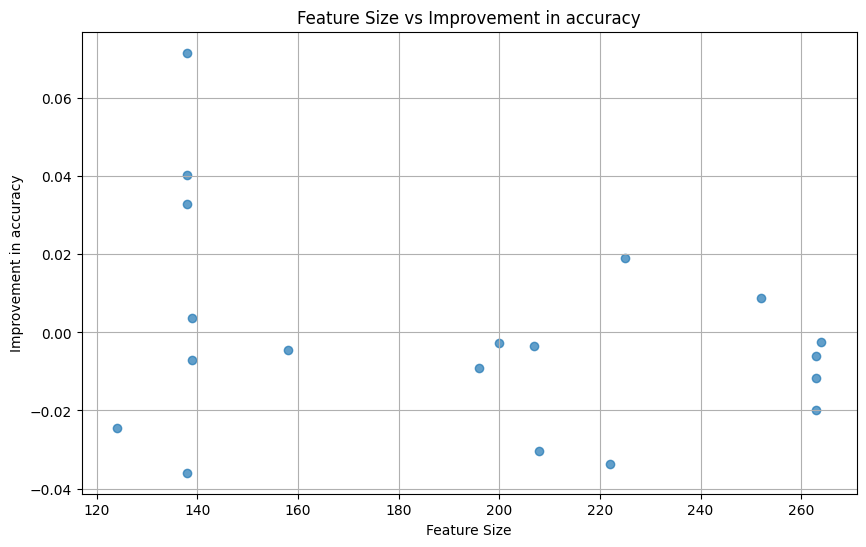

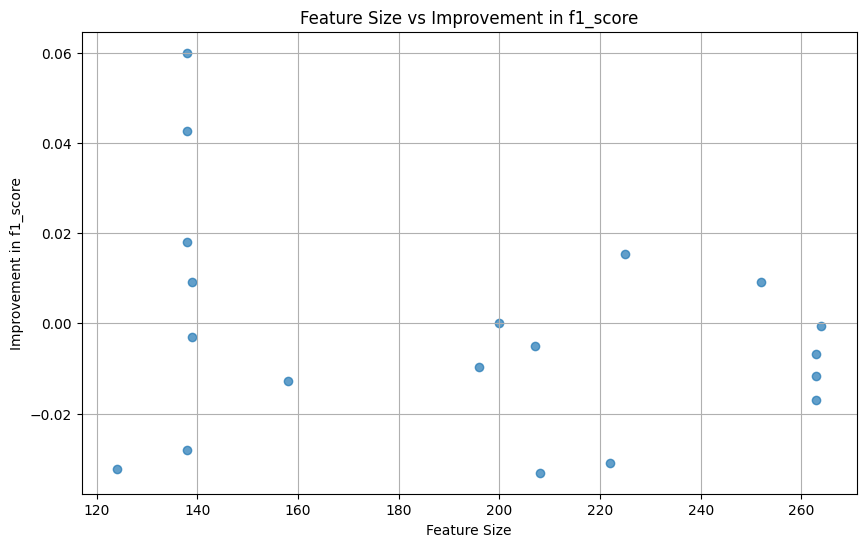

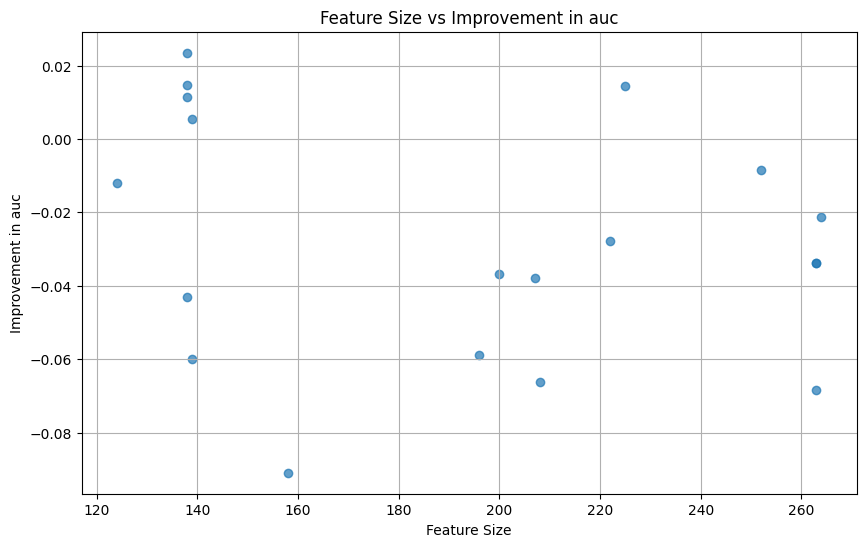

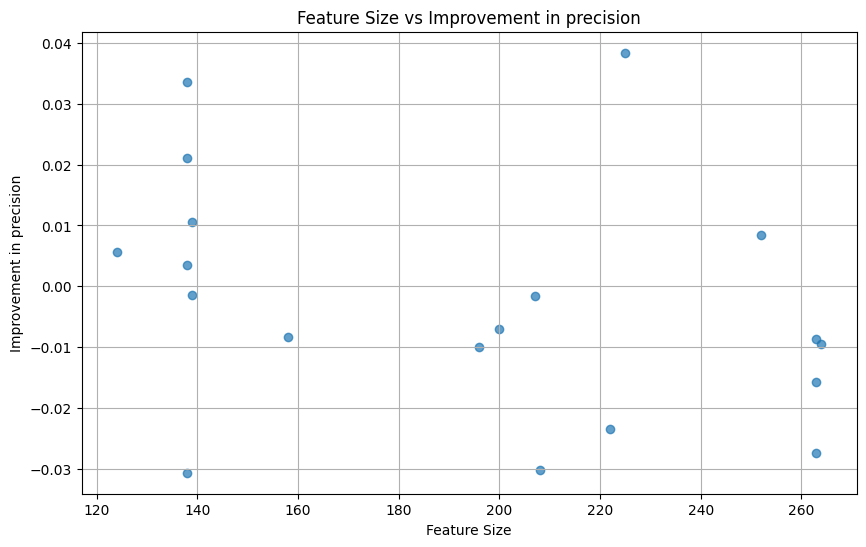

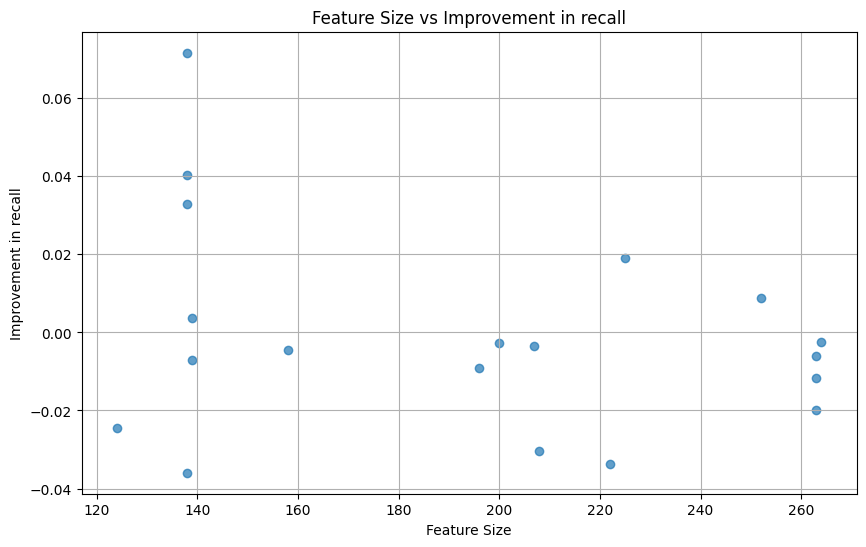

In [36]:
def analyze_correlation_feature_size_and_improvement(results_file, data_sizes_file):
    """
    Analyze correlation between feature size and improvement over baseline metrics for all datasets.

    Parameters:
        results_file (str): Path to the results_metrics.csv file.
        data_sizes_file (str): Path to the data_sizes file containing dataset shapes.

    Returns:
        None
    """
    # Step 1: Read the results file
    if not os.path.exists(results_file):
        print(f"Results file '{results_file}' not found.")
        return
    results_df = pd.read_csv(results_file)
    print("Results file loaded successfully.")

    # Step 2: Load the data_sizes file
    if not os.path.exists(data_sizes_file):
        print(f"Data sizes file '{data_sizes_file}' not found.")
        return
    data_sizes_df = pd.read_csv(data_sizes_file)
    print("Data sizes file loaded successfully.")

    # Step 3: Prepare data for scatter plots
    metrics = ['accuracy', 'f1_score', 'auc', 'precision', 'recall']
    scatter_data = []

    for _, dataset_info in data_sizes_df.iterrows():
        dataset_name = dataset_info['dataset_name']
        feature_size = dataset_info['num_columns'] - 1  # Subtract 1 for the target column

        # Calculate improvement over baseline for each metric
        for metric in metrics:
            proposed_col = f'proposed_{metric}'
            baseline_col = f'baseline_{metric}'
            if proposed_col in results_df.columns and baseline_col in results_df.columns:
                improvement = results_df.loc[results_df['dataset_name'] == dataset_name, proposed_col].values - \
                              results_df.loc[results_df['dataset_name'] == dataset_name, baseline_col].values
                if len(improvement) > 0:
                    scatter_data.append((feature_size, improvement[0], metric, dataset_name))

    # Step 4: Create separate scatter plots for each metric
    for metric in metrics:
        plt.figure(figsize=(10, 6))
        metric_data = [(x, y) for x, y, m, _ in scatter_data if m == metric]
        if metric_data:
            x_values, y_values = zip(*metric_data)
            plt.scatter(x_values, y_values, alpha=0.7)
            plt.xlabel('Feature Size')
            plt.ylabel(f'Improvement in {metric}')
            plt.title(f'Feature Size vs Improvement in {metric}')
            plt.grid()
            plt.show()

# Example usage
results_file = 'results_metrics.csv'  # Path to the results file
data_sizes_file = 'transformed_dataset_sizes.csv'  # Path to the data_sizes file
analyze_correlation_feature_size_and_improvement(results_file, data_sizes_file)

Results file loaded successfully.
Imbalance file loaded successfully.


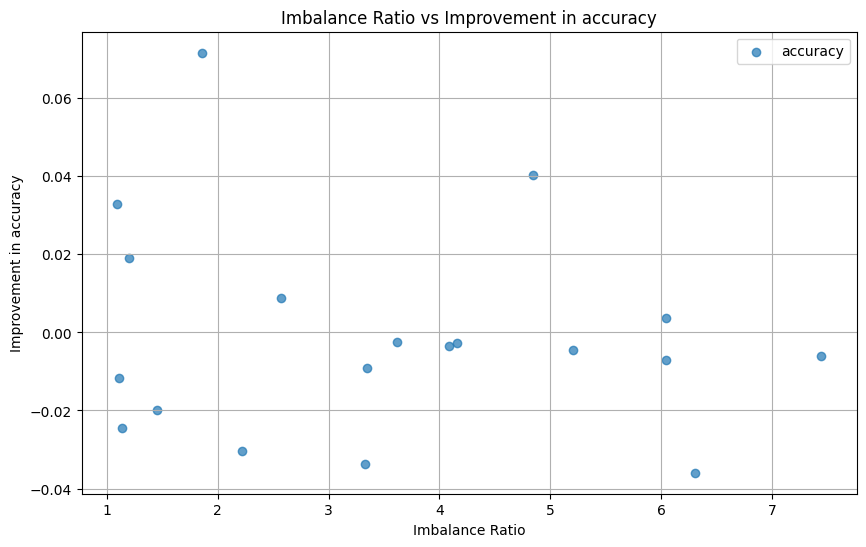

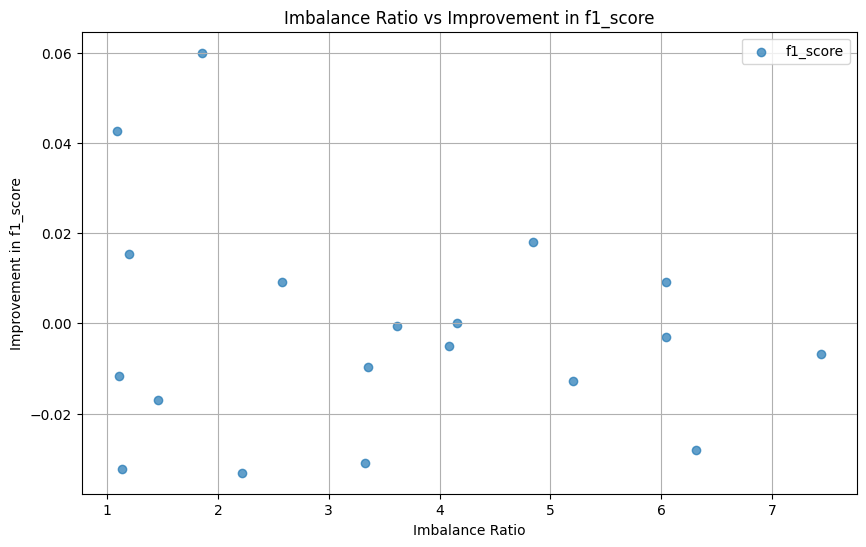

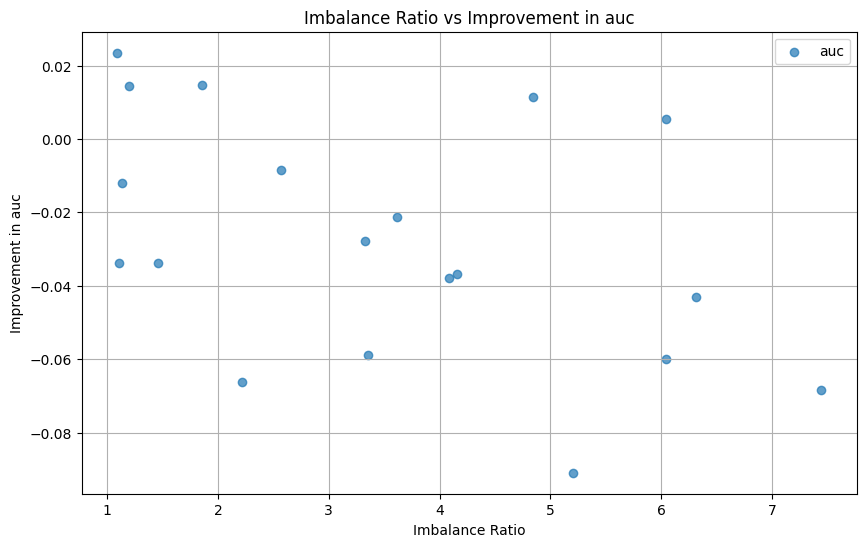

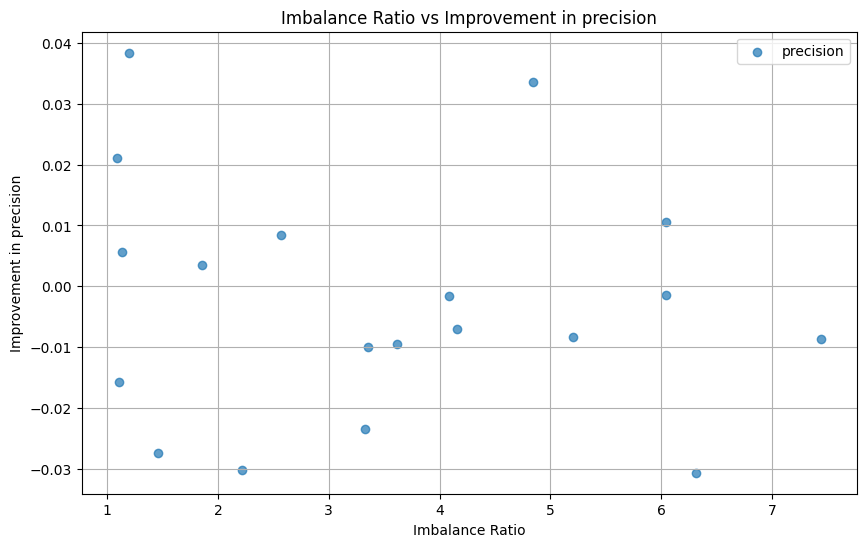

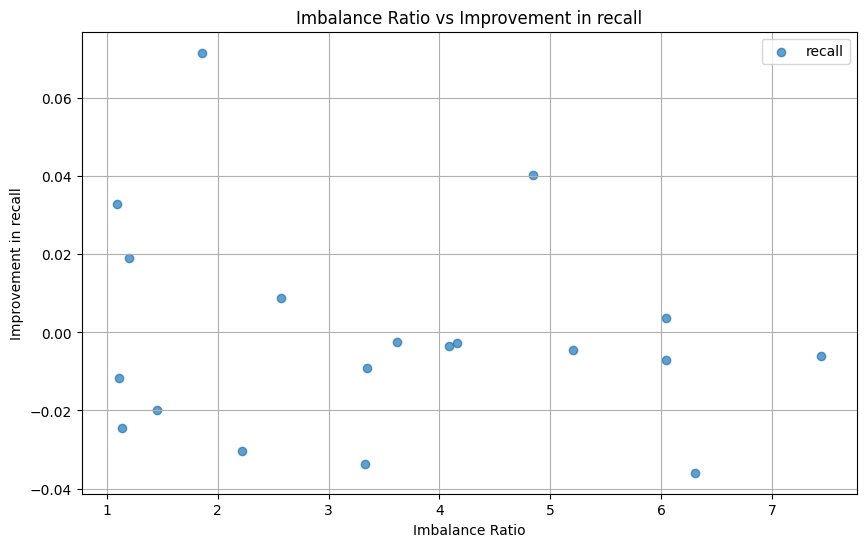

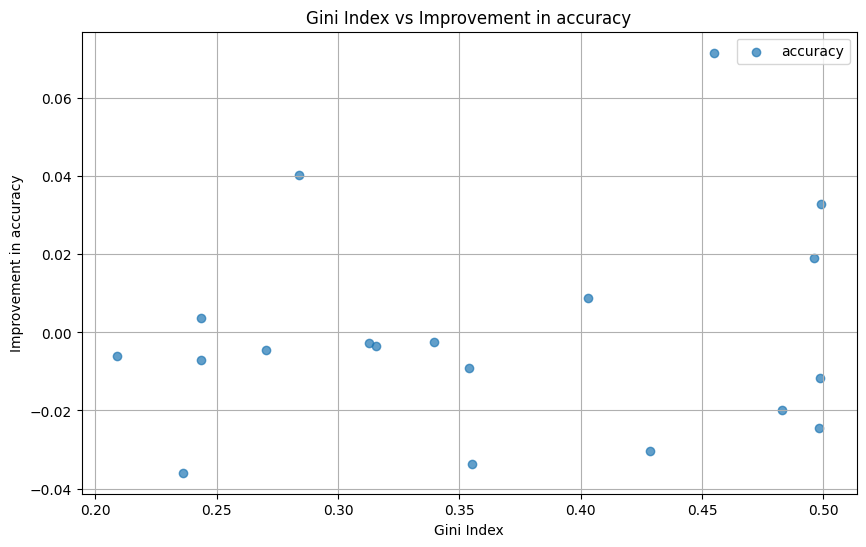

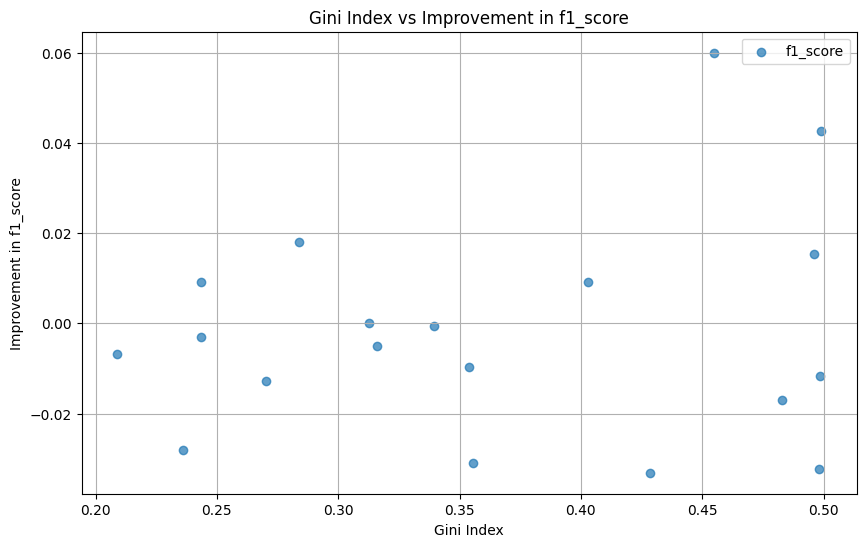

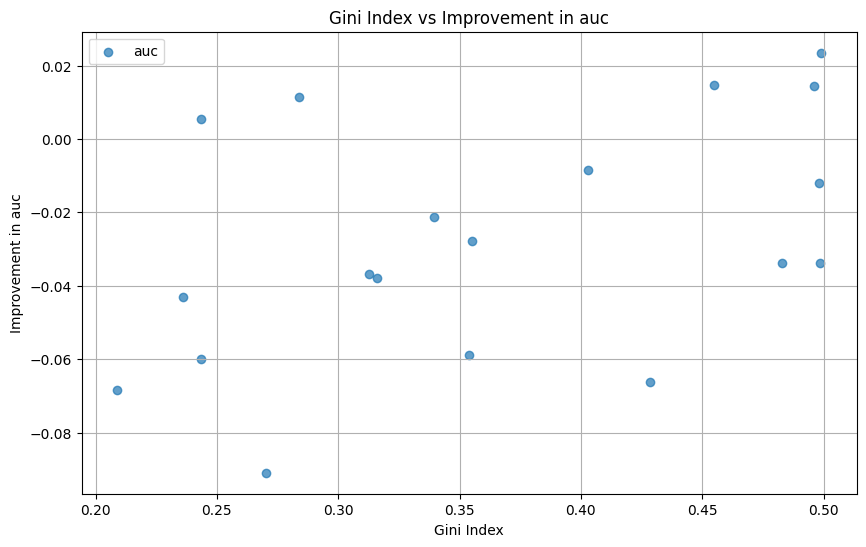

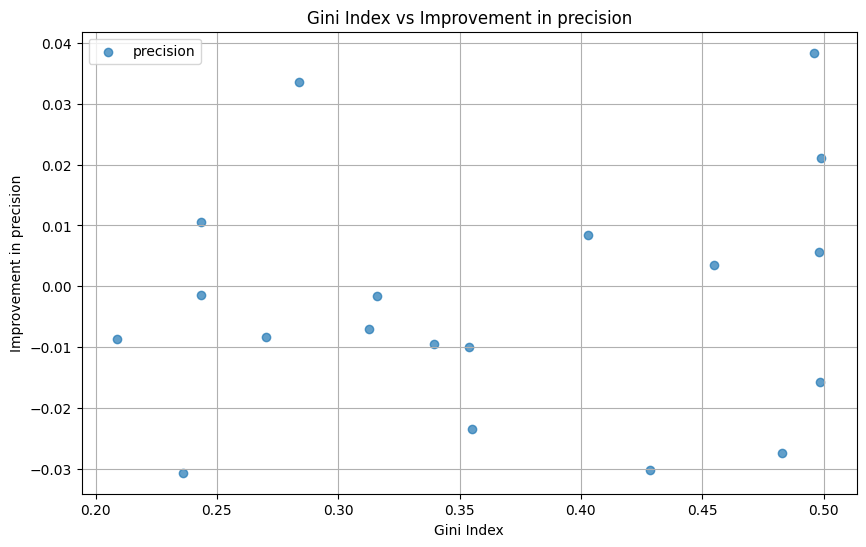

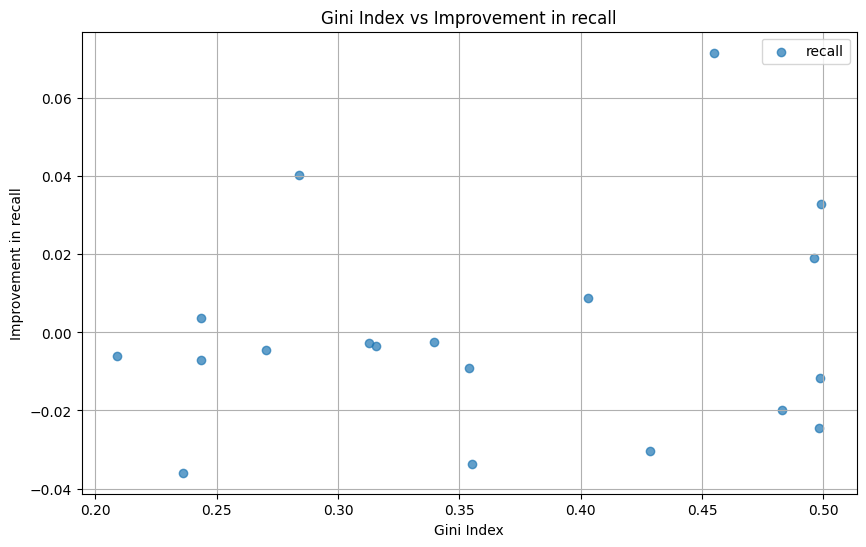

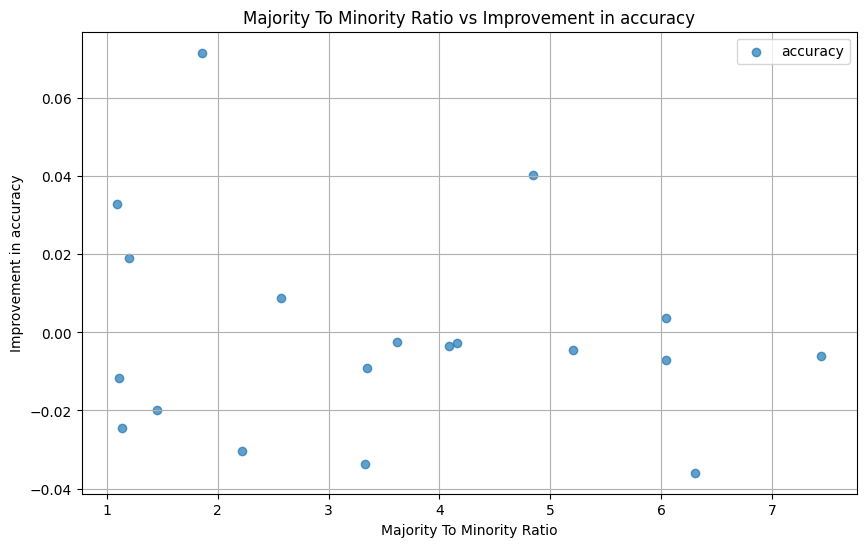

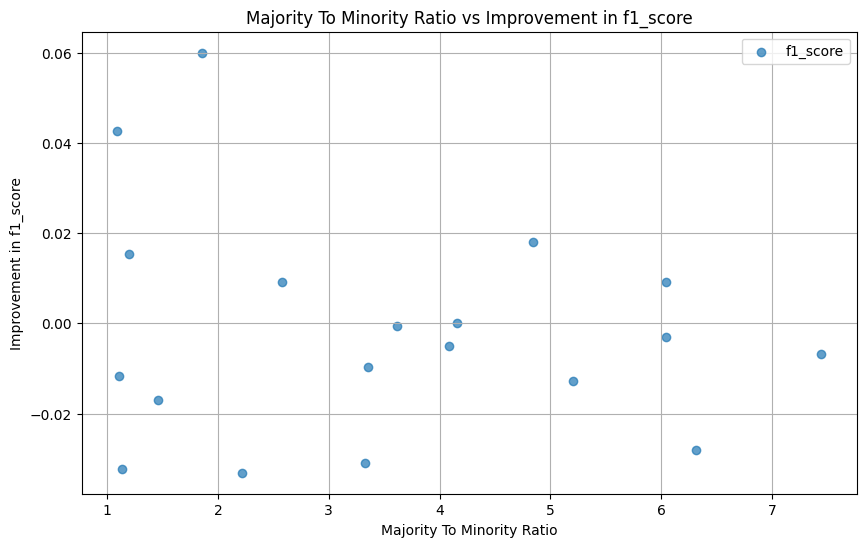

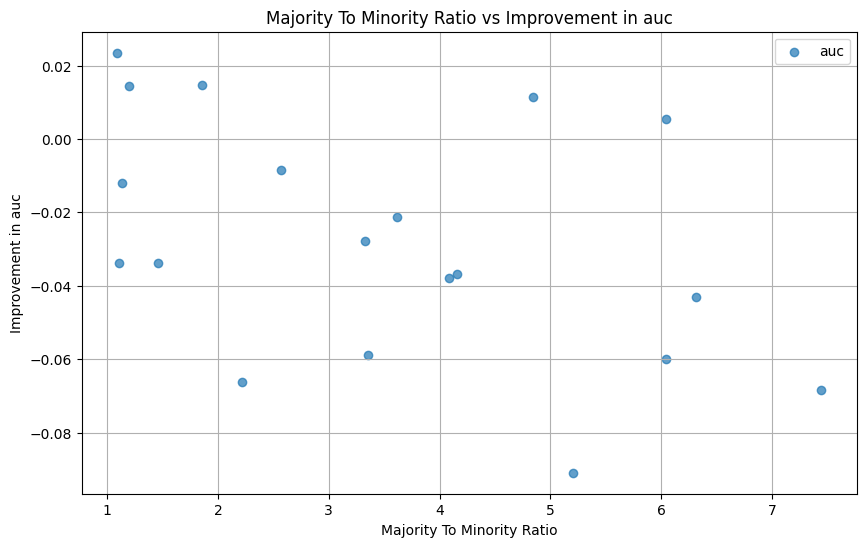

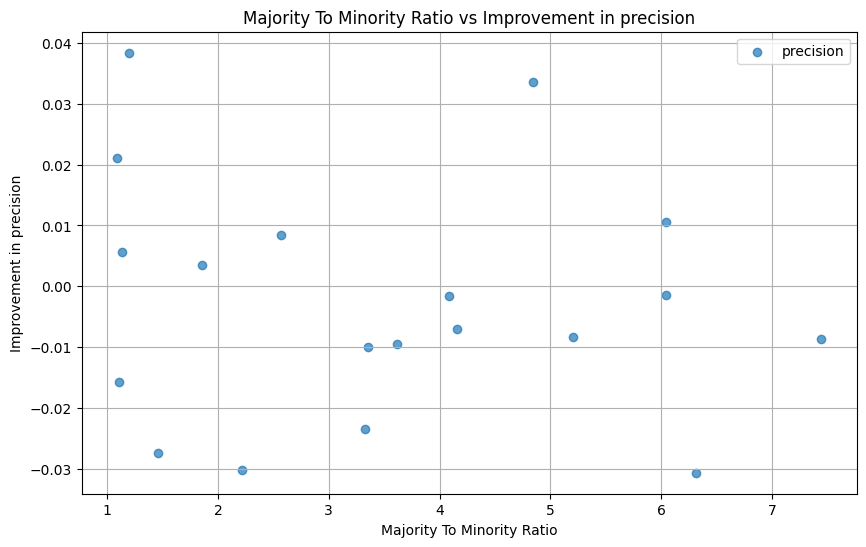

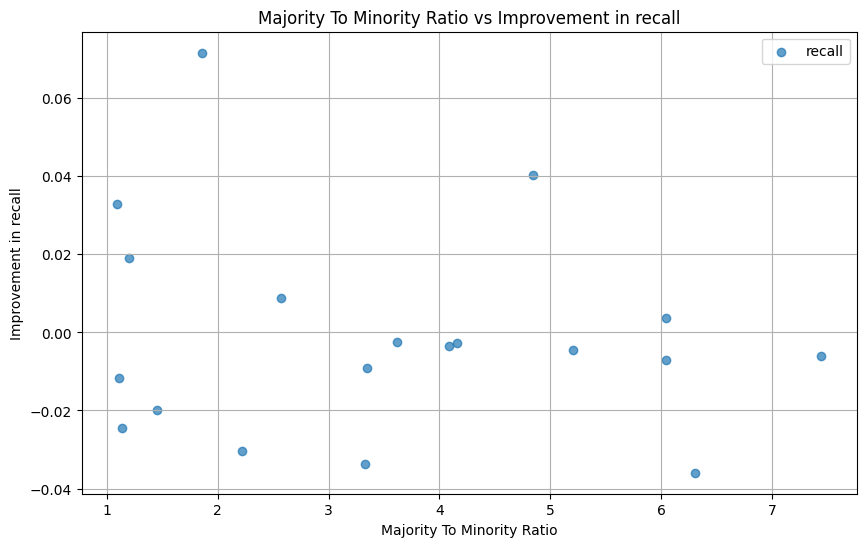

In [37]:
def analyze_correlation_class_imbalance_and_improvement(results_file, imbalance_file):
    """
    Analyze correlation between class imbalance metrics and improvement over baseline metrics for all datasets.

    Parameters:
        results_file (str): Path to the results_metrics.csv file.
        imbalance_file (str): Path to the file containing class imbalance information.

    Returns:
        None
    """
    # Step 1: Read the results file
    if not os.path.exists(results_file):
        print(f"Results file '{results_file}' not found.")
        return
    results_df = pd.read_csv(results_file)
    print("Results file loaded successfully.")

    # Step 2: Load the imbalance file
    if not os.path.exists(imbalance_file):
        print(f"Imbalance file '{imbalance_file}' not found.")
        return
    imbalance_df = pd.read_csv(imbalance_file)
    print("Imbalance file loaded successfully.")

    # Step 3: Prepare data for scatter plots
    metrics = ['accuracy', 'f1_score', 'auc', 'precision', 'recall']
    scatter_data = []

    for _, imbalance_info in imbalance_df.iterrows():
        dataset_name = imbalance_info['dataset_name']
        imbalance_ratio = imbalance_info['imbalance_ratio']
        gini_index = imbalance_info['gini_index']
        majority_to_minority_ratio = imbalance_info['majority_to_minority_ratio']

        # Calculate improvement over baseline for each metric
        for metric in metrics:
            proposed_col = f'proposed_{metric}'
            baseline_col = f'baseline_{metric}'
            if proposed_col in results_df.columns and baseline_col in results_df.columns:
                improvement = results_df.loc[results_df['dataset_name'] == dataset_name, proposed_col].values - \
                              results_df.loc[results_df['dataset_name'] == dataset_name, baseline_col].values
                if len(improvement) > 0:
                    scatter_data.append({
                        "dataset_name": dataset_name,
                        "imbalance_ratio": imbalance_ratio,
                        "gini_index": gini_index,
                        "majority_to_minority_ratio": majority_to_minority_ratio,
                        "improvement": improvement[0],
                        "metric": metric
                    })

    # Step 4: Create scatter plots for each imbalance metric
    imbalance_metrics = ['imbalance_ratio', 'gini_index', 'majority_to_minority_ratio']
    for imbalance_metric in imbalance_metrics:
        for metric in metrics:
            plt.figure(figsize=(10, 6))
            metric_data = [(d[imbalance_metric], d['improvement']) for d in scatter_data if d['metric'] == metric]
            if metric_data:
                x_values, y_values = zip(*metric_data)
                plt.scatter(x_values, y_values, alpha=0.7, label=metric)
                plt.xlabel(imbalance_metric.replace('_', ' ').title())
                plt.ylabel(f'Improvement in {metric}')
                plt.title(f'{imbalance_metric.replace("_", " ").title()} vs Improvement in {metric}')
                plt.grid()
                plt.legend()
                plt.show()

# Example usage
results_file = 'results_metrics.csv'  # Path to the results file
imbalance_file = 'dataset_imbalance_metrics.csv'  # Path to the imbalance file
analyze_correlation_class_imbalance_and_improvement(results_file, imbalance_file)